In [1]:
import itertools
import random
from os.path import join

import numpy as np
import torch
import torch.nn.functional as F
from tensorboardX import SummaryWriter
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms as T
from torchvision.utils import make_grid
from tqdm import tqdm

from facenet_pytorch import MTCNN

from sklearn.metrics import f1_score

from src.config import opt
from src.stylegan_clip import Model
from src.emotion_recognition.model import EmotionModel

import warnings


warnings.filterwarnings("ignore")

In [2]:
def __init_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def calculate_f1(preds, labels):
    return f1_score(labels, preds, average='micro')

In [3]:
class Dataloader:
    def __init__(self, is_eval=False, use_mtcnn=True,):
        self.is_eval = is_eval
        self.use_mtcnn = use_mtcnn
        self.mtcnn = MTCNN(
            image_size=256, margin=0, min_face_size=20,
            thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
            device=opt.device
        )
        self.model = Model(path_to_checkpoint=join(opt.path_to_stylegan_checkpoints, 'neutral'), device=opt.device)

    def prepare_img(self, data, degrees=(0, 0), p_rand=0.5):
        data = data.add(1).div(2).squeeze()
        if not self.is_eval:
            kp_transformations_train = T.Compose([
                T.RandomRotation(degrees=degrees) if p_rand < 0.25 else T.RandomRotation(degrees=(0, 0)),
            ])
            data = kp_transformations_train(data).to(opt.device)

        if self.use_mtcnn:
            data = self.mtcnn(
                data.permute(1, 2, 0).mul(255).detach().cpu().numpy(),
                return_prob=False,
            )
            if data is None:
                return None
            data = data.add(1).div(2).squeeze()
        return data.to(opt.device)  # self.kp_transformations(data).to(opt.device)

    def get_batch(self, batch_size):
        inputs_b, targets_b, emotions_b = [], [], []
        for b in range(batch_size):
            data_0 = None
            data_1 = None
            emo = None
            while data_0 is None or data_1 is None:
                noise = torch.randn(1, 512, device=opt.device)
                emo = random.choice(opt.emotion_list)
                self.model.load_checkpoint(join(opt.path_to_stylegan_checkpoints, emo))
                data = self.model.inference(1, noise)[1:]

                degree = np.random.randint(low=-45, high=45)
                p_rand = float(np.random.rand())
                data_0 = self.prepare_img(data[0], degrees=(degree, degree), p_rand=p_rand)
                data_1 = self.prepare_img(data[1], degrees=(degree, degree), p_rand=p_rand)
            inputs_b.append(data_0.unsqueeze(0))
            target_emotion = torch.zeros([1, 7]).to(opt.device)

            if np.random.rand() < 0.2:
                targets_b.append(data_0.unsqueeze(0))
                emotions_b.append(target_emotion)
            else:
                targets_b.append(data_1.unsqueeze(0))
                target_emotion[:, opt.emotion_list.index(emo)] = 1
                emotions_b.append(target_emotion)
        return torch.cat(inputs_b), torch.cat(targets_b), torch.cat(emotions_b)

In [7]:
import matplotlib.pyplot as plt

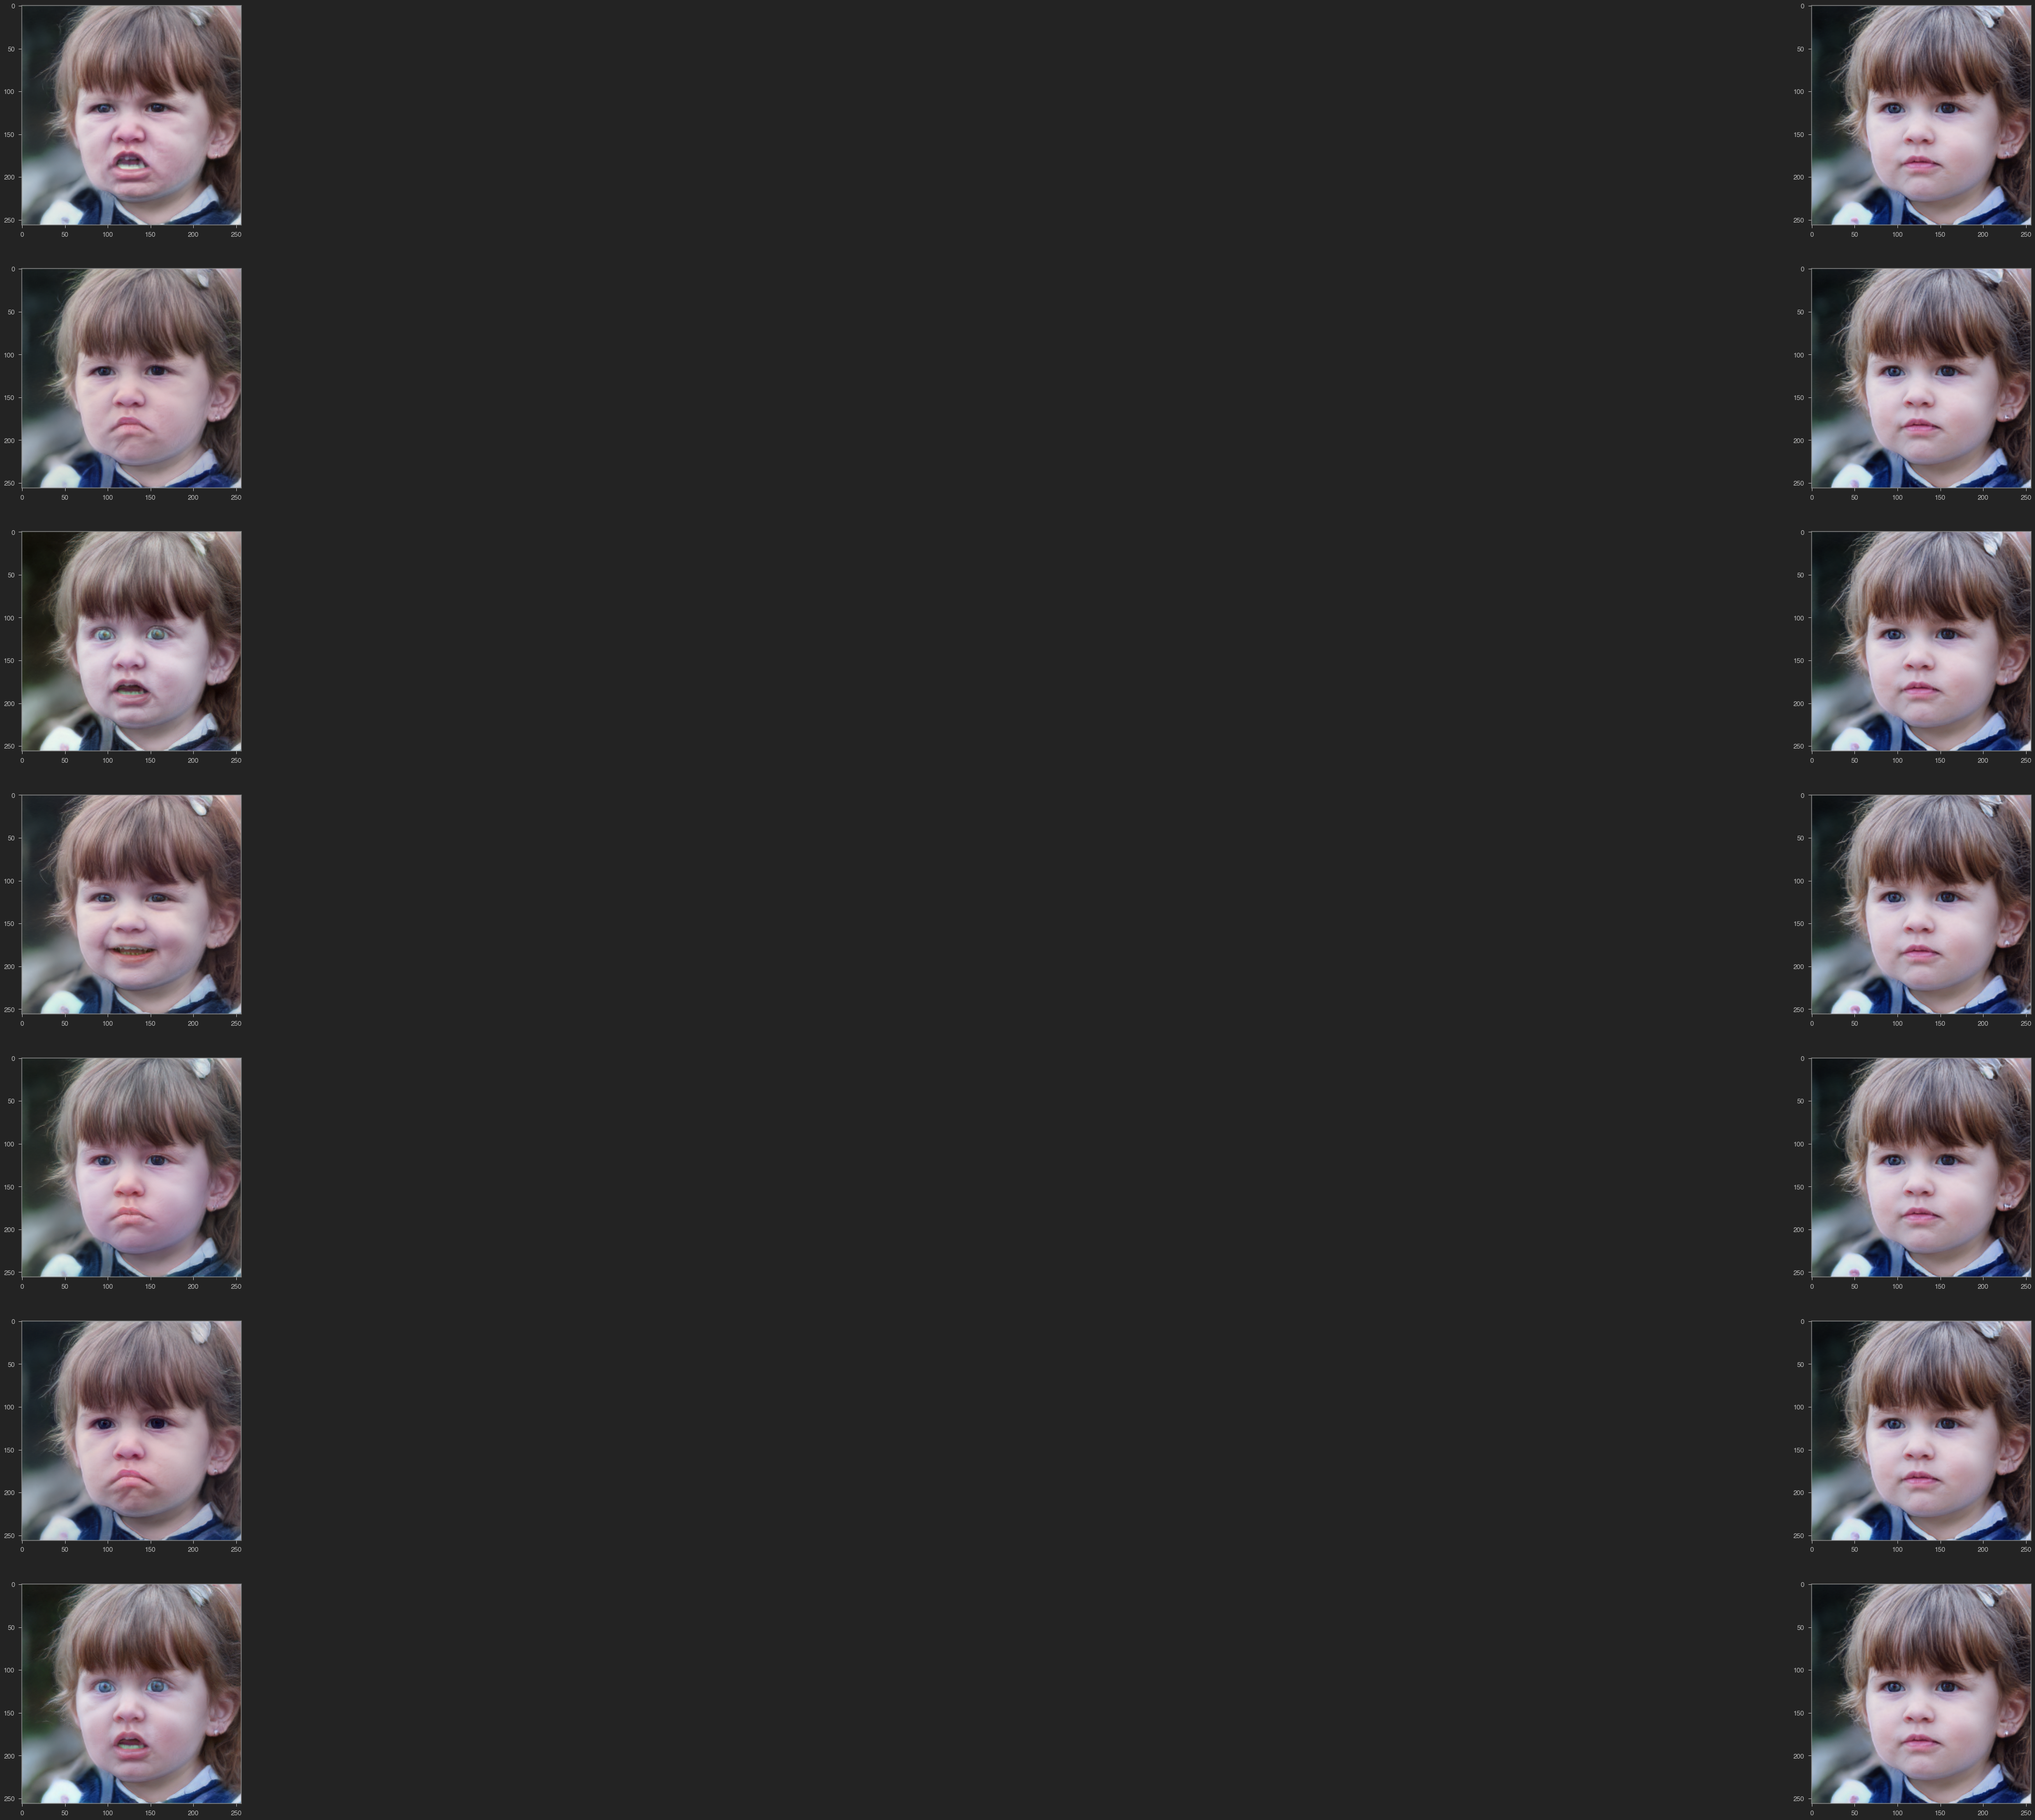

In [50]:
noise = torch.randn(1, 512, device=opt.device)

fig, ax = plt.subplots(len(opt.emotion_list), 2, figsize=(16*len(opt.emotion_list), 9*len(opt.emotion_list)))
for idx, emo in enumerate(opt.emotion_list):
    model = Model(path_to_checkpoint=join(opt.path_to_stylegan_checkpoints, emo), device=opt.device)
    data = model.inference(1, noise)[1:]

    x1 = data[1].squeeze(0).add(1).div(2)
    transform = T.ToPILImage()
    img1 = transform(x1)

    x2 = data[0].squeeze(0).add(1).div(2)
    transform = T.ToPILImage()
    img2 = transform(x2)

    ax[idx][0].imshow(img1)
    ax[idx][1].imshow(img2)

In [43]:
x1 = data[1].squeeze(0).add(1).div(2)
transform = T.ToPILImage()
img1 = transform(x1)

x2 = data[0].squeeze(0).add(1).div(2)
transform = T.ToPILImage()
img2 = transform(x2)
# img.show()

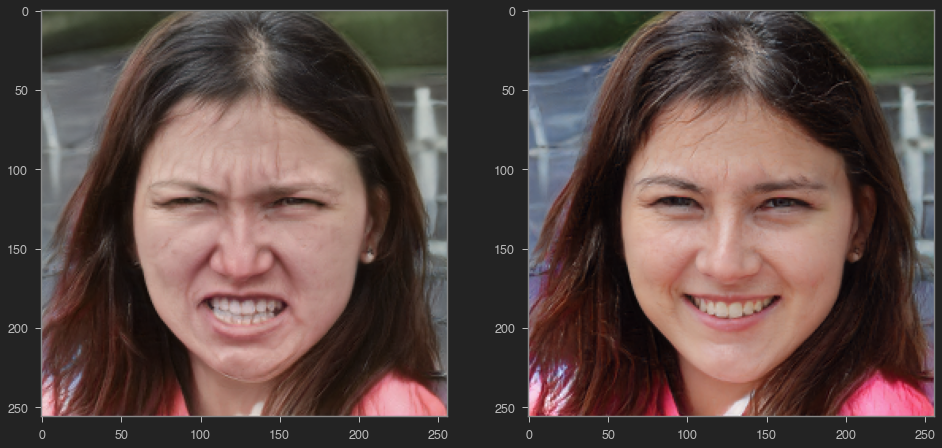

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
ax[0].imshow(img1)
ax[1].imshow(img2)